In [2]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from msfm.utils import scales

24-05-08 04:38:17   imports.py INF   Setting up healpy to run on 32 CPUs 


In [3]:
n_side = 512
n_pix = hp.nside2npix(n_side)
l_min_global = 30
l_max_global = 3 * n_side - 1

# relationship between the Cls and Gaussian white noise sigma

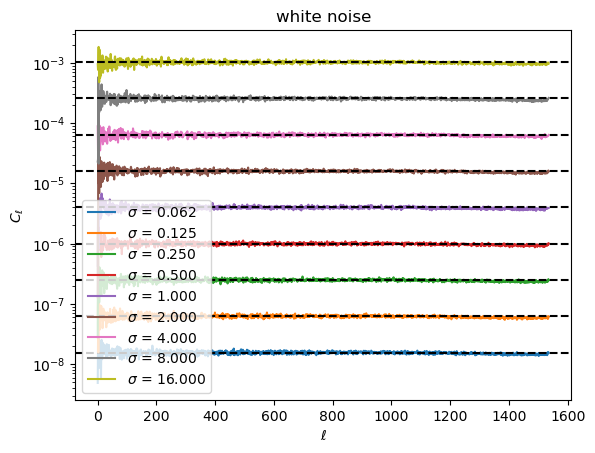

In [3]:
sigmas = np.geomspace(2**-4, 2**4, 9)

fig, ax = plt.subplots()
for sigma in sigmas:
    white_noise_map = np.random.normal(loc=0, scale=sigma, size=n_pix)
    # hp.mollview(white_noise_map, title='White noise map')

    white_noise_cl = hp.anafast(white_noise_map, lmax=l_max_global)
    ell = np.arange(len(white_noise_cl))
    predicted_cl = sigma**2*hp.nside2pixarea(n_side)

    ax.plot(ell, white_noise_cl, label=r"$\sigma$" + f' = {sigma:.3f}')
    ax.axhline(predicted_cl, color='k', linestyle='--')

ax.set(xscale="linear", yscale="log", xlabel=r'$\ell$', ylabel=r'$C_\ell$', title="white noise")
ax.legend()

# smoothing

In [4]:
# load some non-smoothed Cls
with h5py.File("/Users/arne/data/DESY3/cls/v7/fiducial_cls.h5", "r") as f:
    raw_cls = f["cls/raw"][0, :, 21]

print(raw_cls.shape)

# toy version
# raw_cls = np.arange(1, l_max+1)**-3.0

(1536,)


In [5]:
fwhm_arcmin = 30.0
fwhm = scales.arcmin_to_rad(fwhm_arcmin)

l_naive_smooth = scales.angle_to_ell(fwhm, arcmin=False, method="naive")
print(f"Naive smoothig scale: {l_naive_smooth}")

Naive smoothig scale: 360.0


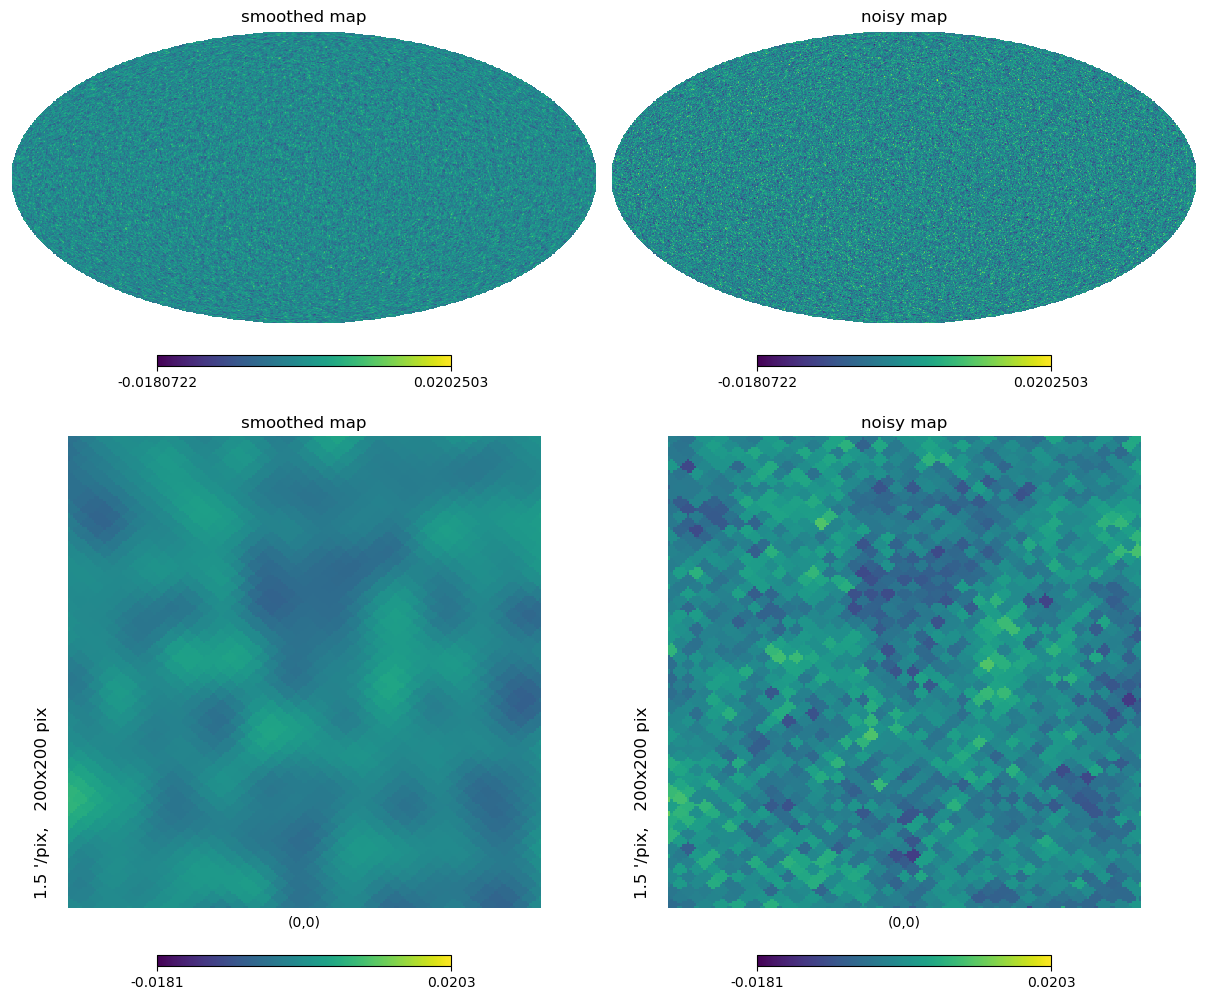

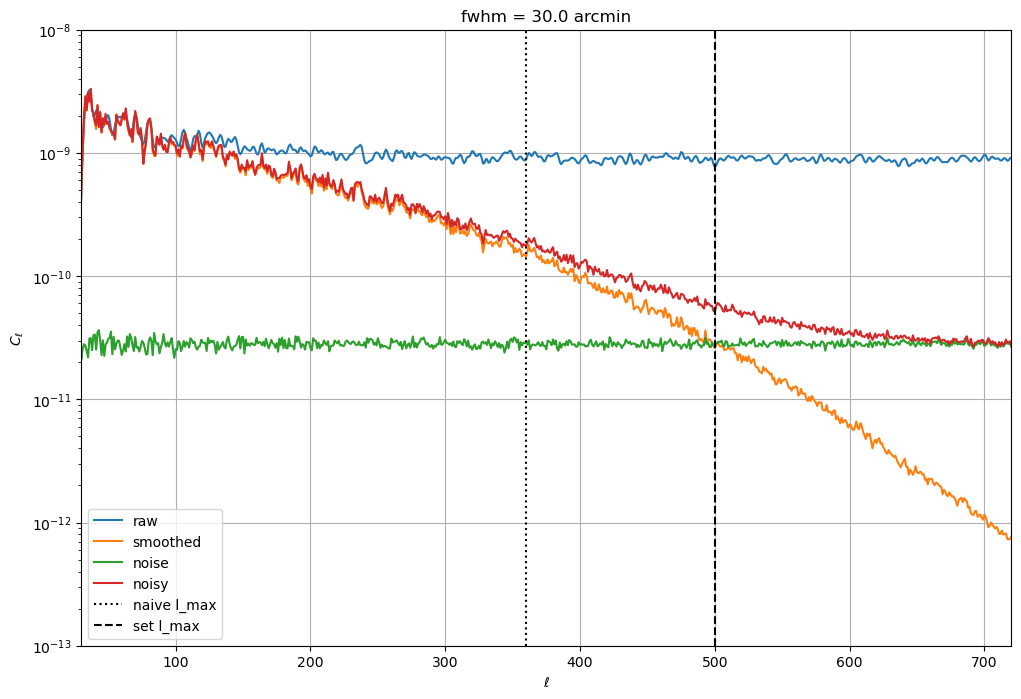

In [9]:
l_max = 500

example_map = hp.synfast(cls=raw_cls, nside=n_side)
smoothed_map = hp.smoothing(example_map, fwhm=fwhm)
smoothed_cls = hp.anafast(smoothed_map, lmax=l_max_global)

noise_level_cl = savgol_filter(smoothed_cls, window_length=20, polyorder=1)[l_max]
sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
noise_map = np.random.normal(loc=0.0, scale=sigma, size=n_pix)
noise_cls = hp.anafast(noise_map, lmax=l_max_global)

noisy_map = smoothed_map + noise_map
noisy_cls = hp.anafast(noisy_map, lmax=l_max_global)

vmin, vmax = noisy_map.min(), noisy_map.max()

plt.figure(figsize=(12,12))
hp.mollview(smoothed_map, title='smoothed map', min=vmin, max=vmax, sub=(2,2,1))
hp.mollview(noisy_map, title='noisy map', min=vmin, max=vmax, sub=(2,2,2))

hp.gnomview(smoothed_map, title='smoothed map', min=vmin, max=vmax, sub=(2,2,3))
hp.gnomview(noisy_map, title='noisy map', min=vmin, max=vmax, sub=(2,2,4))

# smoothed_gnom = hp.gnomview(smoothed_map, title='smoothed map', min=vmin, max=vmax, return_projected_map=True, no_plot=True)
# noisy_gnom = hp.gnomview(noisy_map, title='smoothed map', min=vmin, max=vmax, return_projected_map=True, no_plot=True)

# fig, ax = plt.subplots(figsize=(4,8), nrows=2)
# ax[0].matshow(smoothed_gnom, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
# ax[0].set_title('smoothed map')
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[1].matshow(noisy_gnom, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
# ax[1].set_title('noisy map')
# ax[1].set_xticks([])
# ax[1].set_yticks([])

fig, ax = plt.subplots(figsize=(12,8))
ell = np.arange(len(raw_cls))
ax.plot(ell, raw_cls, label='raw')
ax.plot(ell, smoothed_cls, label='smoothed')
ax.plot(ell, noise_cls, label='noise')
ax.plot(ell, noisy_cls, label='noisy')
# ax.plot(ell, smoothed_cls + noise_cls, label='smoothed + noise')
ax.axvline(l_naive_smooth, color='k', linestyle=':', label='naive l_max')
ax.axvline(l_max, color='k', linestyle='--', label='set l_max')
# ax.axhline(noise_level_cl, color='k', linestyle='--', label='noise level')
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(l_min_global, 2*l_naive_smooth), 
    ylim=(1e-13, 1e-8),
    title=f"fwhm = {fwhm_arcmin} arcmin"
)
ax.grid(True)
ax.legend(loc="lower left");

# sample on the GPU

In [4]:
import tensorflow_probability as tfp

In [19]:
normal = tfp.distributions.Normal(loc=0.0, scale=[1.0, 10.0, 100.0, 1000.0])

In [20]:
batch_size = 96
samples = normal.sample((batch_size, n_pix))

print(samples.shape)

(96, 3145728, 4)


In [27]:
%time
temp = normal.sample((batch_size, n_pix))

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 8.11 µs
